# loading

In [ ]:
!pip install pytorch-lightning==2.2.0
!pip install rasterio
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 54.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [ ]:
# --- 1. environment flags (must be set *before* importing PL) -----------
import os
os.environ["PL_DISABLE_MIXED_IMPORTS"] = "1"   # use *only* pytorch_lightning
os.environ["TORCH_NAN_INF_CHECK"]    = "1"     # raise if any NaN/Inf in fwd/bwd

# --- 2. standard & utility packages ------------------------------------
import sys, shutil, zipfile, csv
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import rasterio
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- 3. PyTorch core ----------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# --- 4. PyTorch Lightning (legacy namespace only) ----------------------
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

# --- 5. Colab conveniences (only if you’re in Colab) -------------------
try:
    from google.colab import drive, files
except ImportError:
    drive = files = None        # not running in Colab → ignore

In [ ]:
drive.mount('/content/drive', force_remount=True)
base_folder = '/content/drive/My Drive/ONLY_TIF'
csv_path = '/content/drive/MyDrive/superres_triplets.csv'
df = pd.read_csv(csv_path)
for col in ['goes1_path', 'goes2_path', 'viirs_path']:
    df[col] = df[col].apply(lambda x: os.path.join(base_folder, x))

df.to_csv(csv_path, index=False)

Mounted at /content/drive


In [ ]:
def make_triplet_csv(source_dir, output_csv_path):
    data = []
    id_counter = 1

    for root, _, files in os.walk(source_dir):
        files = [f for f in files if f.lower().endswith('.tif')]
        if not files:
            continue

        goes1 = goes2 = viirs = None
        for f in files:
            f_lower = f.lower()
            full_path = os.path.join(root, f)
            rel_path = os.path.relpath(full_path, source_dir)

            if 'geo16' in f_lower:
                goes1 = rel_path
            elif 'geo17' in f_lower:
                goes2 = rel_path
            elif 'geo18' in f_lower and goes2 is None:
                goes2 = rel_path
            elif 'combined' in f_lower:
                viirs = rel_path

        if goes1 and goes2 and viirs:
            data.append({
                'id': id_counter,
                'goes1_path': os.path.join(source_dir, goes1),
                'goes2_path': os.path.join(source_dir, goes2),
                'viirs_path': os.path.join(source_dir, viirs),
            })
            id_counter += 1

    df = pd.DataFrame(data)
    df.to_csv(output_csv_path, index=False)
    print(f"✅ CSV saved to {output_csv_path} with {len(df)} records.")

# Define paths
source_dir = "/content/drive/MyDrive/ONLY_TIF/ONLY_TIF"
output_csv_path = "/content/superres_triplets.csv"

make_triplet_csv(source_dir, output_csv_path)

✅ CSV saved to /content/superres_triplets.csv with 1260 records.


# dataset

In [ ]:
class SatelliteImageDataset(Dataset):
    def __init__(self, csv_path, json_path, transform=None):
        """
        Dataset for satellite image super-resolution

        Args:
            csv_path: Path to CSV file with image triplets
            json_path: Path to JSON file with normalization parameters
            transform: Optional transforms to apply to images
        """
        self.df = pd.read_csv(csv_path)

        # Load normalization parameters from JSON
        with open(json_path, 'r') as f:
            self.norm_params = json.load(f)

        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get paths for this sample
        sample = self.df.iloc[idx]
        goes1_path = sample['goes1_path']
        goes2_path = sample['goes2_path']
        viirs_path = sample['viirs_path']

        # Load images using rasterio
        goes1 = self._load_and_process_image(goes1_path, 'goes')
        goes2 = self._load_and_process_image(goes2_path, 'goes')
        viirs = self._load_and_process_image(viirs_path, 'viirs')

        # Apply additional transforms if specified
        if self.transform:
            goes1 = self.transform(goes1)
            goes2 = self.transform(goes2)
            viirs = self.transform(viirs)

        # Return (goes1, goes2), viirs format
        return (goes1, goes2), viirs

    def _load_and_process_image(self, path, img_type):
        """Load, clip and normalize an image"""
        with rasterio.open(path) as src:
            # Use band 7 for GOES and band 1 for VIIRS
            band_idx = 7 if img_type == 'goes' else 1
            img = src.read(band_idx)

        # Handle NaN and Inf values
        mask = ~(np.isnan(img) | np.isinf(img))
        if np.any(mask):
            mean_val = img[mask].mean()
            img = np.where(mask, img, mean_val)
        else:
            img = np.zeros_like(img)

        # Get correct normalization values from JSON
        # JSON has percentile values for GOES and VIIRS
        sat_type = "GOES" if img_type == "goes" else "VIIRS"
        min_val = self.norm_params[sat_type]["p2"]
        max_val = self.norm_params[sat_type]["p98"]

        # Clip values based on image type
        img = np.clip(img, min_val, max_val)

        # # Normalize to [0, 1]
        img = (img - min_val) / (max_val - min_val)

        # Convert to PyTorch tensor and add channel dimension
        img_tensor = torch.from_numpy(img).float().unsqueeze(0)

        return img_tensor


GOES1 shape: torch.Size([1, 100, 100])
GOES2 shape: torch.Size([1, 100, 100])
VIIRS shape: torch.Size([1, 400, 400])


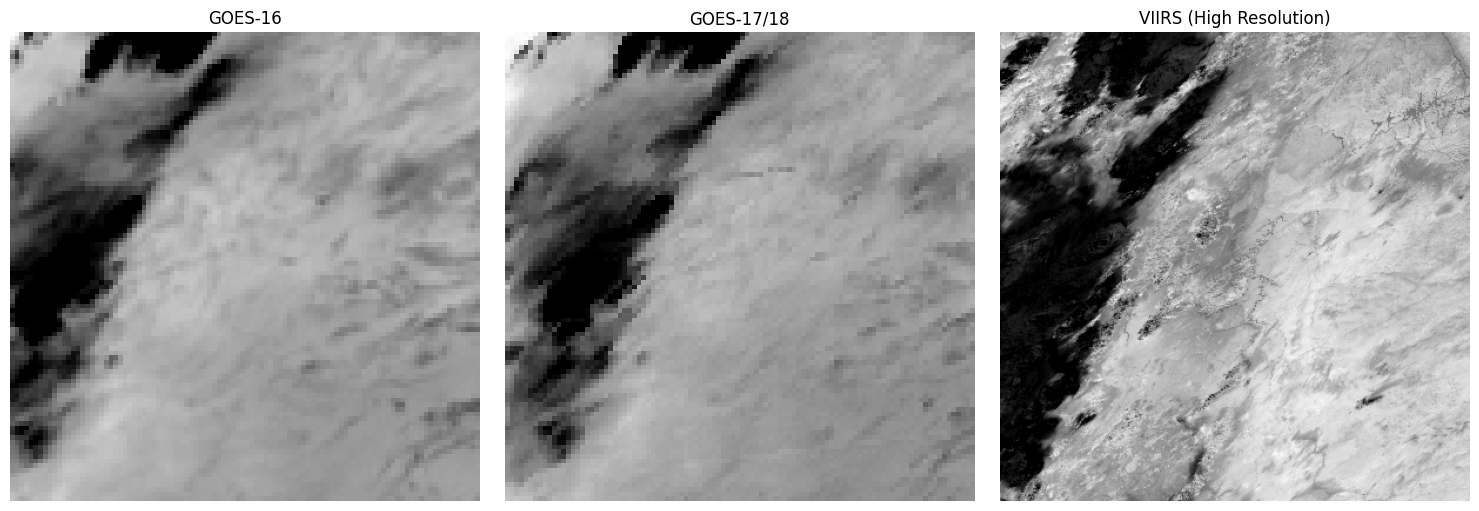

GOES1 range: 0.0000 to 0.7235
GOES2 range: 0.0000 to 0.8294
VIIRS range: 0.0000 to 0.8363


In [ ]:
# Create the dataset
json_path = "/content/radiance_visualization_ranges.json" # Path to your JSON file
csv_path = "/content/superres_triplets.csv"  # Path to your CSV file

# Initialize the dataset
dataset = SatelliteImageDataset(csv_path, json_path)

# Load a single triplet (index 0)
(goes1, goes2), viirs = dataset[2]

# Print shapes
print(f"GOES1 shape: {goes1.shape}")
print(f"GOES2 shape: {goes2.shape}")
print(f"VIIRS shape: {viirs.shape}")

# Visualize the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each image
axs[0].imshow(goes1.squeeze().numpy(), cmap='gray')
axs[0].set_title('GOES-16')
axs[0].axis('off')

axs[1].imshow(goes2.squeeze().numpy(), cmap='gray')
axs[1].set_title('GOES-17/18')
axs[1].axis('off')

axs[2].imshow(viirs.squeeze().numpy(), cmap='gray')
axs[2].set_title('VIIRS (High Resolution)')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Print value ranges to verify normalization
print(f"GOES1 range: {goes1.min().item():.4f} to {goes1.max().item():.4f}")
print(f"GOES2 range: {goes2.min().item():.4f} to {goes2.max().item():.4f}")
print(f"VIIRS range: {viirs.min().item():.4f} to {viirs.max().item():.4f}")

In [ ]:
class SatelliteDataModule(pl.LightningDataModule):
    def __init__(
        self,
        csv_path,
        json_path,
        batch_size=8,
        num_workers=0,
        transform=None,
        val_split=0.2  # Add validation split parameter
    ):
        """
        PyTorch Lightning DataModule for satellite super-resolution

        Args:
            csv_path: Path to CSV file with image triplets
            json_path: Path to JSON file with normalization parameters
            batch_size: Batch size for dataloader
            num_workers: Number of worker processes for data loading
            transform: Optional transforms to apply
            val_split: Fraction of data to use for validation (0.0 to 1.0)
        """
        super().__init__()
        self.csv_path = csv_path
        self.json_path = json_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.val_split = val_split
        self.save_hyperparameters(ignore=['transform'])

    def setup(self, stage=None):
        # Create full dataset
        full_dataset = SatelliteImageDataset(
            csv_path=self.csv_path,
            json_path=self.json_path,
            transform=self.transform
        )

        # Calculate split sizes
        val_size = int(len(full_dataset) * self.val_split)
        train_size = len(full_dataset) - val_size

        # Split into train and validation datasets
        self.train_dataset, self.val_dataset = random_split(
            full_dataset,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(42)  # Fixed seed for reproducibility
        )

        print(f"Training dataset: {len(self.train_dataset)} samples")
        print(f"Validation dataset: {len(self.val_dataset)} samples")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        if self.val_split <= 0:
            return None

        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        # No test data
        return None


In [ ]:
# Test for the SatelliteDataModule
def test_satellite_dataloader():
    # Create the data module
    data_module = SatelliteDataModule(
        csv_path="/content/superres_triplets.csv",
        json_path="/content/radiance_visualization_ranges.json",
        batch_size=10,  # Set batch size to 10 for this test
        num_workers=2
    )

    # Set up the data module
    data_module.setup()

    # Print dataset size
    print(f"Total samples in dataset: {len(data_module.train_dataset)}")

    # Get a batch of 10 samples
    train_batch = next(iter(data_module.train_dataloader()))
    (goes1_batch, goes2_batch), viirs_batch = train_batch

    # Print batch information
    print(f"GOES1 batch shape: {goes1_batch.shape}")
    print(f"GOES2 batch shape: {goes2_batch.shape}")
    print(f"VIIRS batch shape: {viirs_batch.shape}")

    # Print value ranges to check normalization
    print(f"GOES1 value range: [{goes1_batch.min().item():.4f}, {goes1_batch.max().item():.4f}]")
    print(f"GOES2 value range: [{goes2_batch.min().item():.4f}, {goes2_batch.max().item():.4f}]")
    print(f"VIIRS value range: [{viirs_batch.min().item():.4f}, {viirs_batch.max().item():.4f}]")

    # Visualize all 10 samples
    fig, axes = plt.subplots(10, 3, figsize=(15, 40))

    for i in range(10):
        # GOES-16
        axes[i, 0].imshow(goes1_batch[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 0].set_title(f"Sample {i+1}: GOES-16")
        axes[i, 0].axis('off')

        # GOES-17/18
        axes[i, 1].imshow(goes2_batch[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 1].set_title(f"Sample {i+1}: GOES-17/18")
        axes[i, 1].axis('off')

        # VIIRS
        axes[i, 2].imshow(viirs_batch[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 2].set_title(f"Sample {i+1}: VIIRS")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Additional test: check a few more batches to ensure we're getting different samples
    print("\nChecking if we get different samples in different batches...")
    dataloader = data_module.train_dataloader()
    iter_loader = iter(dataloader)

    # Get the first element of the first sample from 3 different batches
    batch1 = next(iter_loader)
    val1 = batch1[0][0][0, 0, 0, 0].item()

    batch2 = next(iter_loader)
    val2 = batch2[0][0][0, 0, 0, 0].item()

    batch3 = next(iter_loader)
    val3 = batch3[0][0][0, 0, 0, 0].item()

    print(f"First pixel values from 3 different batches: {val1:.4f}, {val2:.4f}, {val3:.4f}")
    print(f"All different: {val1 != val2 and val2 != val3 and val1 != val3}")

    return "Test completed successfully!"

# # Run the test
# test_satellite_dataloader()

# callbacks

In [ ]:
class LossPlottingCallback(Callback):
    def __init__(self, output_dir=None):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.epochs = []

        # If output_dir is not provided, create one with timestamp
        if output_dir is None:
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            self.output_dir = os.path.join("/content/checkpoints", f"losses_{timestamp}")
        else:
            self.output_dir = output_dir

        os.makedirs(self.output_dir, exist_ok=True)

        # Path to save loss CSV
        self.csv_path = os.path.join(self.output_dir, "loss_history.csv")
        # Write CSV header
        with open(self.csv_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["epoch", "train_loss", "val_loss"])

    def on_train_epoch_end(self, trainer, pl_module):
        # Get current epoch number
        epoch = trainer.current_epoch
        self.epochs.append(epoch)

        # Get the logged metrics
        train_loss = trainer.callback_metrics.get("train_loss", None)
        if train_loss is not None:
            train_loss = train_loss.item()
            self.train_losses.append(train_loss)

        val_loss = trainer.callback_metrics.get("val_loss", None)
        if val_loss is not None:
            val_loss = val_loss.item()
            self.val_losses.append(val_loss)

        # Log to CSV
        with open(self.csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch,
                             train_loss if train_loss is not None else "N/A",
                             val_loss if val_loss is not None else "N/A"])

        # Plot and save losses
        self._plot_losses()

    def _plot_losses(self):
        plt.figure(figsize=(10, 6))

        if self.train_losses:
            plt.plot(self.epochs, self.train_losses, 'b-', label='Training Loss')

        if self.val_losses:
            plt.plot(self.epochs, self.val_losses, 'r-', label='Validation Loss')

        plt.title('Loss During Training')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save the plot
        plt.savefig(os.path.join(self.output_dir, f"loss_plot_epoch_{self.epochs[-1]:03d}.png"))
        plt.close()

In [ ]:
class VisualizePredictionCallback(Callback):
    def __init__(self, goes1_path, goes2_path, viirs_path, every_n_epochs=1):
        super().__init__()
        self.goes1_path = goes1_path
        self.goes2_path = goes2_path
        self.viirs_path = viirs_path
        self.every_n_epochs = every_n_epochs

        # Load visualization scaling values from JSON
        with open("/content/radiance_visualization_ranges.json", "r") as f:
            self.ranges = json.load(f)

        # Make output directory with timestamp
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        self.output_dir = os.path.join("/content/checkpoints", f"visual_{timestamp}")
        os.makedirs(self.output_dir, exist_ok=True)

    def _load_and_normalize_image(self, path, band=1, is_viirs=False):
        """Load and normalize an image using same method as dataset"""
        with rasterio.open(path) as src:
            image = src.read(band).astype(np.float32)

        # Handle NaN/Inf values
        mask = ~(np.isnan(image) | np.isinf(image))
        if np.any(mask):
            mean_val = image[mask].mean()
            image = np.where(mask, image, mean_val)
        else:
            image = np.zeros_like(image)

        # Normalize using same method as SatelliteImageDataset
        sat_type = "VIIRS" if is_viirs else "GOES"
        min_val = self.ranges[sat_type]["p2"]
        max_val = self.ranges[sat_type]["p98"]

        # Clip and normalize to [0,1]
        image = np.clip(image, min_val, max_val)
        image = (image - min_val) / (max_val - min_val)

        return image

    def on_train_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch
        if epoch % self.every_n_epochs != 0:
            return

        # Load and normalize images the same way as dataset
        goes1_img = self._load_and_normalize_image(self.goes1_path, band=7)
        goes2_img = self._load_and_normalize_image(self.goes2_path, band=7)
        viirs_img = self._load_and_normalize_image(self.viirs_path, band=1, is_viirs=True)

        # Convert to tensors
        goes1_tensor = torch.from_numpy(goes1_img).unsqueeze(0).unsqueeze(0).to(pl_module.device)
        goes2_tensor = torch.from_numpy(goes2_img).unsqueeze(0).unsqueeze(0).to(pl_module.device)

        # Run prediction
        with torch.no_grad():
            predicted = pl_module(goes1_tensor, goes2_tensor).squeeze().cpu().numpy()

            # Debug information
            print(f"Prediction stats - min: {predicted.min():.6f}, max: {predicted.max():.6f}, mean: {predicted.mean():.6f}")
            print(f"Prediction shape: {predicted.shape}, VIIRS shape: {viirs_img.shape}")

            # If prediction is all near zero, amplify for visualization
            if predicted.max() < 0.1:
                print("Warning: Prediction values are very small - amplifying for visualization")
                # Try to amplify signal for visualization without changing actual model output
                viz_predicted = predicted.copy()
                if viz_predicted.max() > 0:
                    viz_predicted = viz_predicted / viz_predicted.max()  # Normalize to [0,1] for visibility
                else:
                    viz_predicted = predicted  # If all zeros, don't change
            else:
                viz_predicted = predicted

            # Handle NaN in prediction
            viz_predicted = np.nan_to_num(viz_predicted, nan=0.0, posinf=1.0, neginf=0.0)
            # Ensure prediction is in [0,1] range
            viz_predicted = np.clip(viz_predicted, 0, 1)

        # Plot all 4 images side by side
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        titles = ["GOES-1", "GOES-2", "VIIRS (GT)", "Predicted"]
        images = [goes1_img, goes2_img, viirs_img, viz_predicted]

        for ax, img, title in zip(axs, images, titles):
            im = ax.imshow(img, cmap="gray", vmin=0, vmax=1.0)
            ax.set_title(title)
            ax.axis("off")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        plt.suptitle(f"Epoch {epoch}", fontsize=16)
        plt.tight_layout()
        save_path = os.path.join(self.output_dir, f"epoch_{epoch:03d}.png")
        plt.savefig(save_path)
        plt.close()
        print(f"✅ Saved visualization to {save_path}")

In [ ]:
class PSNRValidationCallback(Callback):
    """
    Compute corrected PSNR (Kelvin metric) on a fixed month of triplets.
    Logs cPSNR scores per epoch into a CSV in vis_callback.output_dir
    """

    def __init__(self, vis_callback, val_month_dir, every_n_epochs=1):
        super().__init__()
        self.vis_callback   = vis_callback
        self.val_month_dir  = val_month_dir
        self.every_n_epochs = every_n_epochs

        # Read radiometric range for VIIRS
        with open("/content/radiance_visualization_ranges.json") as f:
            rng = json.load(f)
        self.vi_min = rng["VIIRS"]["p2"]
        self.vi_rng = rng["VIIRS"]["p98"] - self.vi_min

        # Collect validation triplets
        self.triplets = self._collect_triplets(val_month_dir)
        if not self.triplets:
            print("[WARNING] No validation triplets found — skipping PSNR computation.")

        # CSV output path
        self.csv_path = os.path.join(self.vis_callback.output_dir, "cpsnr_log.csv")
        # Write header if file doesn't exist yet
        if not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["epoch", "cpsnr"])

    @staticmethod
    def _collect_triplets(root):
        out = []
        for cur, _, files in os.walk(root):
            files = [f for f in files if f.lower().endswith(".tif")]
            if not files:
                continue
            g1 = g2 = v = None
            for f in files:
                p = os.path.join(cur, f)
                lf = f.lower()
                if "geo16" in lf:
                    g1 = p
                elif "geo17" in lf or ("geo18" in lf and g2 is None):
                    g2 = p
                elif "viirs" in lf or "combined" in lf:
                    v = p
            if g1 and g2 and v:
                out.append((g1, g2, v))
            else:
                print(f"[WARNING] Incomplete triplet in {cur} → g1: {bool(g1)}, g2: {bool(g2)}, v: {bool(v)}")
        return out

    @staticmethod
    def _load_band(path):
        is_viirs   = "viirs" in path.lower() or "combined" in path.lower()
        band_index = 1 if is_viirs else 7
        with rasterio.open(path) as src:
            img = src.read(band_index).astype(np.float32)
        m = ~(np.isnan(img) | np.isinf(img))
        return np.where(m, img, img[m].mean() if m.any() else 0.0)

    @staticmethod
    def cpsnr(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> float:
        diff = (gt - pred) * mask
        b    = diff.sum() / (mask.sum() + 1e-8)
        cmse = ((gt - pred + b) ** 2 * mask).sum() / (mask.sum() + 1e-8)
        return -10.0 * np.log10(cmse + 1e-8)

    def on_train_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch
        if (epoch + 1) % self.every_n_epochs:
            return

        psnrs = []

        for g1_path, g2_path, v_path in self.triplets:
            g1 = self._load_band(g1_path)
            g2 = self._load_band(g2_path)
            vi = self._load_band(v_path)

            # Normalize ground truth VIIRS
            vi_scaled = np.clip((vi - self.vi_min) / self.vi_rng, 0, 1)

            # Predict using scaled GOES inputs
            pred = pl_module(
                torch.from_numpy(g1)[None, None].to(pl_module.device),
                torch.from_numpy(g2)[None, None].to(pl_module.device)
            ).squeeze().detach().cpu().numpy()

            psnrs.append(self.cpsnr(vi_scaled, pred, np.ones_like(vi_scaled)))

        mean_psnr = float(np.mean(psnrs))
        if not hasattr(pl_module, "psnr_scores"):
            pl_module.psnr_scores = []
        pl_module.psnr_scores.append(mean_psnr)

        # Save PSNR plot
        plot_path = os.path.join(self.vis_callback.output_dir, f"psnr_curve_epoch_{epoch:03d}.png")
        plt.figure()
        plt.plot(pl_module.psnr_scores, marker='o')
        plt.title("Validation cPSNR")
        plt.xlabel("epoch")
        plt.ylabel("dB")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.close()

        # Append to CSV log
        with open(self.csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, round(mean_psnr, 4)])

        print(f"📈  epoch {epoch:03d}  mean cPSNR: {mean_psnr:.2f} dB")

# model

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl


class EnhancedSatelliteSuperResolutionModel(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, scale_factor=4, base_filters=64):
        super().__init__()
        r = scale_factor // 2  # will be 2 if scale_factor==4

        # --- encoders (unchanged) ---
        self.encoder1 = nn.Sequential(
            # First block
            nn.Conv2d(in_channels, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            # Second block
            nn.Conv2d(base_filters, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*2, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            # Third block
            nn.Conv2d(base_filters*2, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*4, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True)
        )
        self.encoder2 = nn.Sequential(
            # identical to encoder1
            nn.Conv2d(in_channels, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*2, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*2, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*4, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True)
        )

        # --- fusion (unchanged) ---
        self.fusion = nn.Sequential(
            nn.Conv2d(base_filters*8, base_filters*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*8),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*8, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*4, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True)
        )

        # --- two‐stage PixelShuffle upsampling with an intermediate conv ---
        # Stage 1: 1× → 2×
        self.up1 = nn.Sequential(
            nn.Conv2d(base_filters*4, base_filters*4 * (r**2), kernel_size=3, padding=1),
            nn.PixelShuffle(r),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
        )
        # Intermediate “middle” conv
        self.up_mid = nn.Sequential(
            nn.Conv2d(base_filters*4, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
        )
        # Stage 2: 2× → 4×
        self.up2 = nn.Sequential(
            nn.Conv2d(base_filters*4, out_channels * (r**2), kernel_size=3, padding=1),
            nn.PixelShuffle(r),
        )

        # Final activation & clamp
        self.final_activation = nn.ReLU()
        self._initialize_weights()

    def forward(self, x1, x2):
        feat1 = self.encoder1(x1)
        feat2 = self.encoder2(x2)
        fused = self.fusion(torch.cat([feat1, feat2], dim=1))

        # upsample pipeline
        x = self.up1(fused)      # 1×→2×
        x = self.up_mid(x)       # deepen at 2×
        x = self.up2(x)          # 2×→4×

        x = self.final_activation(x)
        return torch.clamp(x, 0.0, 1.0)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


class EnhancedSatelliteSuperResolutionSystem(pl.LightningModule):
    def __init__(self, in_channels=1, out_channels=1,
                 scale_factor=4, base_filters=64, lr=1e-5):
        super().__init__()
        self.model         = EnhancedSatelliteSuperResolutionModel(
            in_channels, out_channels, scale_factor, base_filters
        )
        self.l1_loss       = nn.L1Loss()
        self.mse_loss      = nn.MSELoss()
        self.lr            = lr
        self.grad_clip_val = 1.0

        self.save_hyperparameters()

    def forward(self, x1, x2):
        return self.model(x1, x2)

    def training_step(self, batch, batch_idx):
        (lr1, lr2), hr = batch
        lr1, lr2, hr = map(torch.nan_to_num, (lr1, lr2, hr))
        sr = self(lr1, lr2)
        loss = self.l1_loss(sr, hr) + self.mse_loss(sr, hr)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        (lr1, lr2), hr = batch
        lr1, lr2, hr = map(torch.nan_to_num, (lr1, lr2, hr))
        sr = self(lr1, lr2)
        loss = self.l1_loss(sr, hr) + self.mse_loss(sr, hr)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='min', factor=0.5, patience=5, verbose=True
        )
        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor":   "val_loss",
                "interval":  "epoch",
            },
        }

    def on_before_optimizer_step(self, optimizer):
        torch.nn.utils.clip_grad_norm_(self.parameters(), self.grad_clip_val)


# init callbacks

In [ ]:
pl_model = EnhancedSatelliteSuperResolutionSystem()
vis_callback = VisualizePredictionCallback(
    goes1_path="/content/drive/MyDrive/ONLY_TIF/ONLY_TIF/2020-11/2020-11-01_20-12/clipped_geo16.tif",
    goes2_path="/content/drive/MyDrive/ONLY_TIF/ONLY_TIF/2020-11/2020-11-01_20-12/clipped_geo17.tif",
    viirs_path="/content/drive/MyDrive/ONLY_TIF/ONLY_TIF/2020-11/2020-11-01_20-12/combined_clip.tif",
    every_n_epochs=1  # Visualize every epoch
)

# Create PSNR validation callback
psnr_callback = PSNRValidationCallback(
    vis_callback=vis_callback,
    val_month_dir="/content/drive/MyDrive/ONLY_TIF/ONLY_TIF/2023-02/",  # Directory containing validation month data
    every_n_epochs=1  # Compute PSNR every epoch
)
# Data module
data_module = SatelliteDataModule(
        csv_path="/content/superres_triplets.csv",
        json_path="/content/radiance_visualization_ranges.json",
        batch_size=8,  # Set batch size to 10 for this test
        num_workers=0
    )
loss_callback = LossPlottingCallback(output_dir=vis_callback.output_dir)  # Share the same directory as vis_callback

In [ ]:
torch.cuda.empty_cache()

In [ ]:


# Data module with validation split
data_module = SatelliteDataModule(
    csv_path="/content/superres_triplets.csv",
    json_path="/content/radiance_visualization_ranges.json",
    batch_size=16,
    num_workers=0,
    val_split=0.2  # 20% for validation
)
torch.cuda.empty_cache()

# Create trainer with all callbacks
trainer = Trainer(
    max_epochs=30,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=10,
    callbacks=[psnr_callback, vis_callback, loss_callback],  # Add loss_callback
    gradient_clip_val=1.0,
    detect_anomaly=True
)

# Train model
trainer.fit(pl_model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                                  | Params
-------------------------------------------------------------------
0 | model    | EnhancedSatelliteSuperResolutionModel | 9.4 M 
1 | l1_loss  | L1Loss                                | 0     
2 | mse_loss | MSELoss                               | 0     
------------------------------------------

Training dataset: 1008 samples
Validation dataset: 252 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 24.12 MiB is free. Process 2780 has 14.71 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 366.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# prompt: make a script that will zip the checkpoints folder and then download the folder

# Zip the checkpoints folder
zip_filename = "checkpoints.zip"
!zip -r {zip_filename} /content/checkpoints

# Download the zip file
files.download(zip_filename)